# Food Vision Using EfficientNet CNN Model

In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


### Importing some helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-07-21 19:38:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-07-21 19:38:57 (76.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-07-21 19:38:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-07-21 19:38:58 (69.3 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



### Downloading dataset from TensorFlow Datasets

In [ ]:
import tensorflow_datasets as tfds
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned as (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.EHQ4VR_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.EHQ4VR_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### Features of Food101 dataset

In [ ]:
# Features
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Classes
ds_info.features["label"].names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
train_data.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in train_data.take(1):
  print(image.shape)
  print(image.dtype)
  print(label)
  print(ds_info.features["label"].int2str(label))


(512, 512, 3)
<dtype: 'uint8'>
tf.Tensor(23, shape=(), dtype=int64)
churros


In [ ]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 54,  14,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       ...,

       [[108,  31,  49],
        [106,  29,  47],
        [105,  28,  46],
        ...,
        [121,  38,  56],
        [122,  39,  59],
        [123,  40,  60]],

       [[107,  30,  48],
        [107,  30,  48],
        [107,  30,  48],
        ...,
        [121,  38,  58],
        [123,  40,  60],
        [123,  40,  60]],

       [[106,  29,  47],
        [108,  31,  49],
        [109,  32,  50],
        ...,
        [123,  40,  6

In [ ]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=9>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

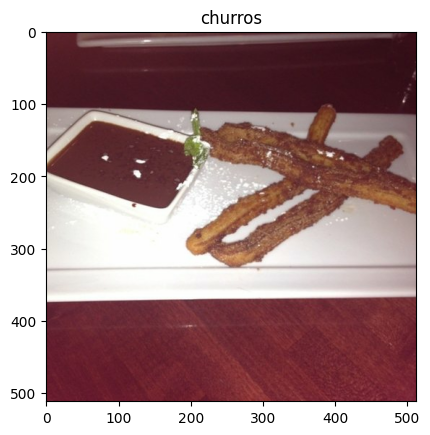

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(ds_info.features["label"].int2str(label));

### Preprocessing functions for our data

* Scaling the data
* Converting the data in float32 datatype to utilise mixed precision training
* Batching the tensors



In [ ]:
def preprocess_img(image, label, img_shape=224):
    '''
    Converts image datatype from uint8 -> float32 and reshapes
    image to [image_shape, image_shape, color_channels]
    '''

    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label

In [ ]:
# Testing the preprocessing function
preprocessed_image=preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}, {image.shape}, {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_image[:2]}, {preprocessed_image.shape}, {preprocessed_image.dtype}")

Image before preprocessing:
 [[[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]

 [[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]], (512, 512, 3), <dtype: 'uint8'>

Image after preprocessing:
 [[[93.       34.       40.      ]
  [94.       35.       41.      ]
  [95.       36.       42.      ]
  ...
  [55.       15.       24.      ]
  [52.       15.       23.      ]
  [52.       15.       23.      ]]

 [[93.92857  34.928574 40.928574]
  [93.07143  34.071426 40.071426]
  [94.       35.       41.      ]
  ...
  [55.       15.       24.      ]
  [54.       14.       23.      ]
  [52.       15.       23.      ]]], (224, 224, 3), <dtype: 'float32'>


### Batching and preparing the datasets

In [ ]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=16).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=16).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Creating Modelling Callbacks

In [ ]:
# Tensorboard callback
from helper_functions import create_tensorboard_callback

# Model Checkpoint callback
checkpoint_path = "model_checkpoints/cp.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=0)



### Setting up mixed precision training

In [ ]:
import tensorflow
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

### Build Feature Extraction Model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import preprocessing

#Base Model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Functional Model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x  = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(ds_info.features["label"].names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

#Compilation of the Model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])




16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
#Checking layer dtype policies
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling2d True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [ ]:
for layer in model.layers:
  if(layer.name=="efficientnetb0"):
    for layer in layer.layers:
      print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer False float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16"

### Fit the feature extraction model

In [ ]:
history_101_food_classes_fe = model.fit(train_data,
                                       epochs=3,
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data,
                                       validation_steps=int(0.15 * len(test_data)),
                                       callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                             experiment_name= "efficientnetb0_feature_extraction"),
                                                  model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_feature_extraction/20250721-195230
Epoch 1/3
3179/4735 ━━━━━━━━━━━━━━━━━━━━ 2:16:32 5s/step - accuracy: 0.4627 - loss: 2.3249

KeyboardInterrupt: 

In [ ]:
# Testing the feature extracted model
loss = 0.0
accuracy = 0.0
num_samples = ds_info.splits["validation"].num_examples

for batch_data, batch_label in test_data:
    batch_loss, batch_accuracy = model.test_on_batch(batch_data, batch_label)
    batch_size_actual = tf.shape(batch_data)[0]
    loss += batch_loss * tf.cast(batch_size_actual, tf.float32)
    accuracy += batch_accuracy * tf.cast(batch_size_actual, tf.float32)

loss /= num_samples
accuracy /= num_samples

print(f"Loss: {loss.numpy():.4f}")
print(f"Accuracy: {accuracy.numpy():.4f}")


### Finetuning the base model

In [ ]:
# Unfreezing the bottom 30 layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [ ]:
# Recompile the entire model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# Fit the finetuned model
history_101_food_classes_ft = model.fit(train_data,
                                       epochs=5,
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data,
                                       validation_steps=int(0.15 * len(test_data)),
                                       callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                             experiment_name= "efficientnetb0_fine_tuning"),
                                                  model_checkpoint])

In [ ]:
# Testing the fine tuned model
import numpy as np

y_true = []
y_pred = []

loss = 0.0
accuracy = 0.0
num_samples = ds_info.splits["validation"].num_examples

for batch_data, batch_label in test_data:
    # 1. Evaluate batch
    batch_loss, batch_accuracy = model.test_on_batch(batch_data, batch_label)
    batch_size_actual = tf.shape(batch_data)[0]
    loss += batch_loss * tf.cast(batch_size_actual, tf.float32)
    accuracy += batch_accuracy * tf.cast(batch_size_actual, tf.float32)

    # 2. Collect predictions for visualization
    preds = model.predict(batch_data, verbose=0)
    pred_labels = np.argmax(preds, axis=1)

    y_true.extend(batch_label.numpy())
    y_pred.extend(pred_labels)

# 3. Normalize final scores
loss /= num_samples
accuracy /= num_samples

print(f"Loss: {loss.numpy():.4f}")
print(f"Accuracy: {accuracy.numpy():.4f}")


In [ ]:
# Plotting the results
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Convert to NumPy arrays
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)

# Get class names
class_names = ds_info.features["label"].names
num_classes = len(class_names)

# Compute per-class accuracy
per_class_accuracy = []
for i in range(num_classes):
    mask = y_true_np == i
    if np.sum(mask) == 0:
        acc = 0  # Avoid division by zero
    else:
        acc = accuracy_score(y_true_np[mask], y_pred_np[mask])
    per_class_accuracy.append(acc)

# Create DataFrame for plotting
import pandas as pd
df = pd.DataFrame({
    "Class": class_names,
    "Accuracy": per_class_accuracy
})

# Sort by accuracy
df_sorted = df.sort_values("Accuracy", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="Class", y="Accuracy", palette="viridis")
plt.xticks(rotation=90)
plt.title("Per-Class Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Class")
plt.tight_layout()
plt.show()


In [ ]:
# Trying to predict an image of internet
def predict_image(model, img_path, class_names, img_shape=224):
    # Load and decode the image
    img_raw = tf.io.read_file(img_path)
    img_tensor = tf.image.decode_jpeg(img_raw, channels=3)

    # Preprocess using your function (just pass a dummy label, e.g., 0)
    img_processed, _ = preprocess_img(img_tensor, label=0, img_shape=img_shape)

    # Add batch dimension
    img_processed = tf.expand_dims(img_processed, axis=0)

    # Make prediction
    preds = model.predict(img_processed)
    pred_class = tf.argmax(preds, axis=1).numpy()[0]
    pred_label = class_names[pred_class]

    return pred_label
